In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

In [2]:
def generate_plot(src_path='x_test_sample.csv', img_path='sample1.png'):
    data = pd.read_csv(src_path)
    display(data.head())
    plt.figure(figsize=(16,4), dpi=200)
    sns.lineplot(x=np.linspace(0,data.shape[1],data.shape[1]), y=data.iloc[0,:])
    plt.ylim([0,1])
    plt.savefig(img_path, dpi=200)
    plt.show()
    return

# Goal
Build a neural network that can accurately estimate parameters of a sine function, even when noise is added. Data can then be used to pretrain a network working with sinusoidal type data.

# Variations in Synthetic Data
- **Sine Wave**:  
    - `period` : period of each sign wave, target variable  
    - `amplitude` : amplitude associated with the sine wave  
    - `phase` : where the sine wave starts horizontally
    - `offset` : y location of the sine wave
- **Noise**:
    - `noise distribution` : generating distribution for the noise added to the wave
    - `noise magnitude` : magnitude of noise added to the sine wave
    - `noise method` : multiplicative or additive noise
- **Additional**:
    - `padding` : how values are padded, primarily concerning if sine waves are repeated for multiple periods or only a single period with padding values
    - `slant` : 
    

# Eventual Supervision Labels

- Sine/Flat : int
- Sine/Flat/Noisy : int
- % Sine vs Flat : float
- Denoised : array_like
- Period/Parameters : float/array_like
- Sine Indices : array_like

## Constants

In [3]:
SINE_LEN = 251
N_EPOCHS = 200
NOISE_SAMPLES = 12

## Noise Generation

In [4]:
def add_noise(arr, distribution='gaussian', symmetric=True, noise_amplitude=1, method='additive', bias=0):
    noise_len = len(arr)
    match distribution:
        case 'gaussian':
            dist = st.norm(0,.5)
        case 'beta':
            dist = st.beta(0,1)
        case 'levy':
            dist = st.levy(0,1)
        case 'uniform':
            dist = st.uniform(0,1)
        case 'pareto':
            dist = st.power(0,1)
        case 't':
            dist = st.t(4,0,1)
    noise_arr = dist.rvs(size=noise_len)
    if bias:
        noise_arr = np.add(noise_arr, bias)
    if symmetric and distribution in ['beta','pareto']:
        random_indices = np.random.randint(0,1).astype(bool)
        noise_arr[random_indices] = -noise_arr[random_indices]
    if method == 'additive':
        arr = np.add(arr, noise_arr)
    elif method == 'multiplicative':
        arr = np.multiply(arr, noise_arr)
    else:
        raise ValueError(f'{method} not recognized as noise method')
    return arr

## Sine Wave Generation

In [5]:
def return_copy(func):
    def wrapper(*args, **kwargs):
        output = func(*args, **kwargs)
        return deepcopy(output)
    return wrapper

def recursive_copy(func):
    def wrapper(*args, **kwargs):
        instances = list()
        filt_iter = lambda x : isinstance(x[1], (list, np.ndarray))
        prev = None
        for key, vals in filter(filt_iter, kwargs.items()):
            for val in vals:
                func_kwargs = deepcopy(kwargs) # dictionary method for this?
                func_kwargs[key] = val
                output = func(*args, prev=prev, **func_kwargs)
                prev = deepcopy(output)
                instances.append(prev)
        return instances
    return wrapper

class WaveGen():
    def __init__(self, size=100, sample_level='total', prev=None):
        self.size = size
        self.sample_level = sample_level
        self.prev = prev
        
        self.x = None
        self.wave = None
        
        self._bias = 0
        self._amp = 1
        
        self.indices = None
        return
    
    def linear_phase(self, phase_angle=0, n_periods=5):
        self.x = np.linspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
    
    def geometric_phase(self, phase_angle=0, n_periods=0):
        # Test if this is ever useful
        self.x = np.geomspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
   
    def cos(self):
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.cos(self.x)
        return self
    
    def _ensure_sin(self):
        if self.x is None:
            self = self.linear_phase()
        if self.wave is None:
            self = self.sin()
        return self
    
    def sin(self):
        # won't be meaningful until adjustments to x are made
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.sin(self.x)
        return self
        
    def bias(self, bias=0):
        self._bias = bias
        return self
    
    def amp(self, amp=1):
        self._amp = amp
        return self
    
    def _assemble(self):
        self = self._ensure_sin()
        self.wave *= self._amp
        self.wave += self._bias
        return self
    
    def pad(self, left_pad=0, right_pad=0):    
        self.left_pad = left_pad
        self.right_pad = right_pad
        return self
    
    def noise_patch(self, start=0, stop=-1, **noise_kwargs):
        raise NotImplementedError
        return self
    
    def gaussian_noise(self, indices=None, loc=0, std=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.normal(loc, std, size=(n_samples, len(indices)))
        return self
    
    def t_noise(self, indices=None, loc=0, std=1, dof=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.standard_t(dof, size=(n_samples, len(self.indices))) * std + loc
        return self
    
    def sample(self, n_samples=1000):
        self = self._assemble()
        if self.indices is None: 
            print('Entered')
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32)
        wave = np.expand_dims(self.wave, axis=0) # broadcast
        background = np.zeros((n_samples, wave.shape[1]), dtype=np.float32)
        background[:,self.indices] = self.noise(n_samples) 
        samples = wave + background
        return samples

large_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5)
small_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.05).t_noise(std=.01, dof=5)
flat_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.005).t_noise(std=.01, dof=5)

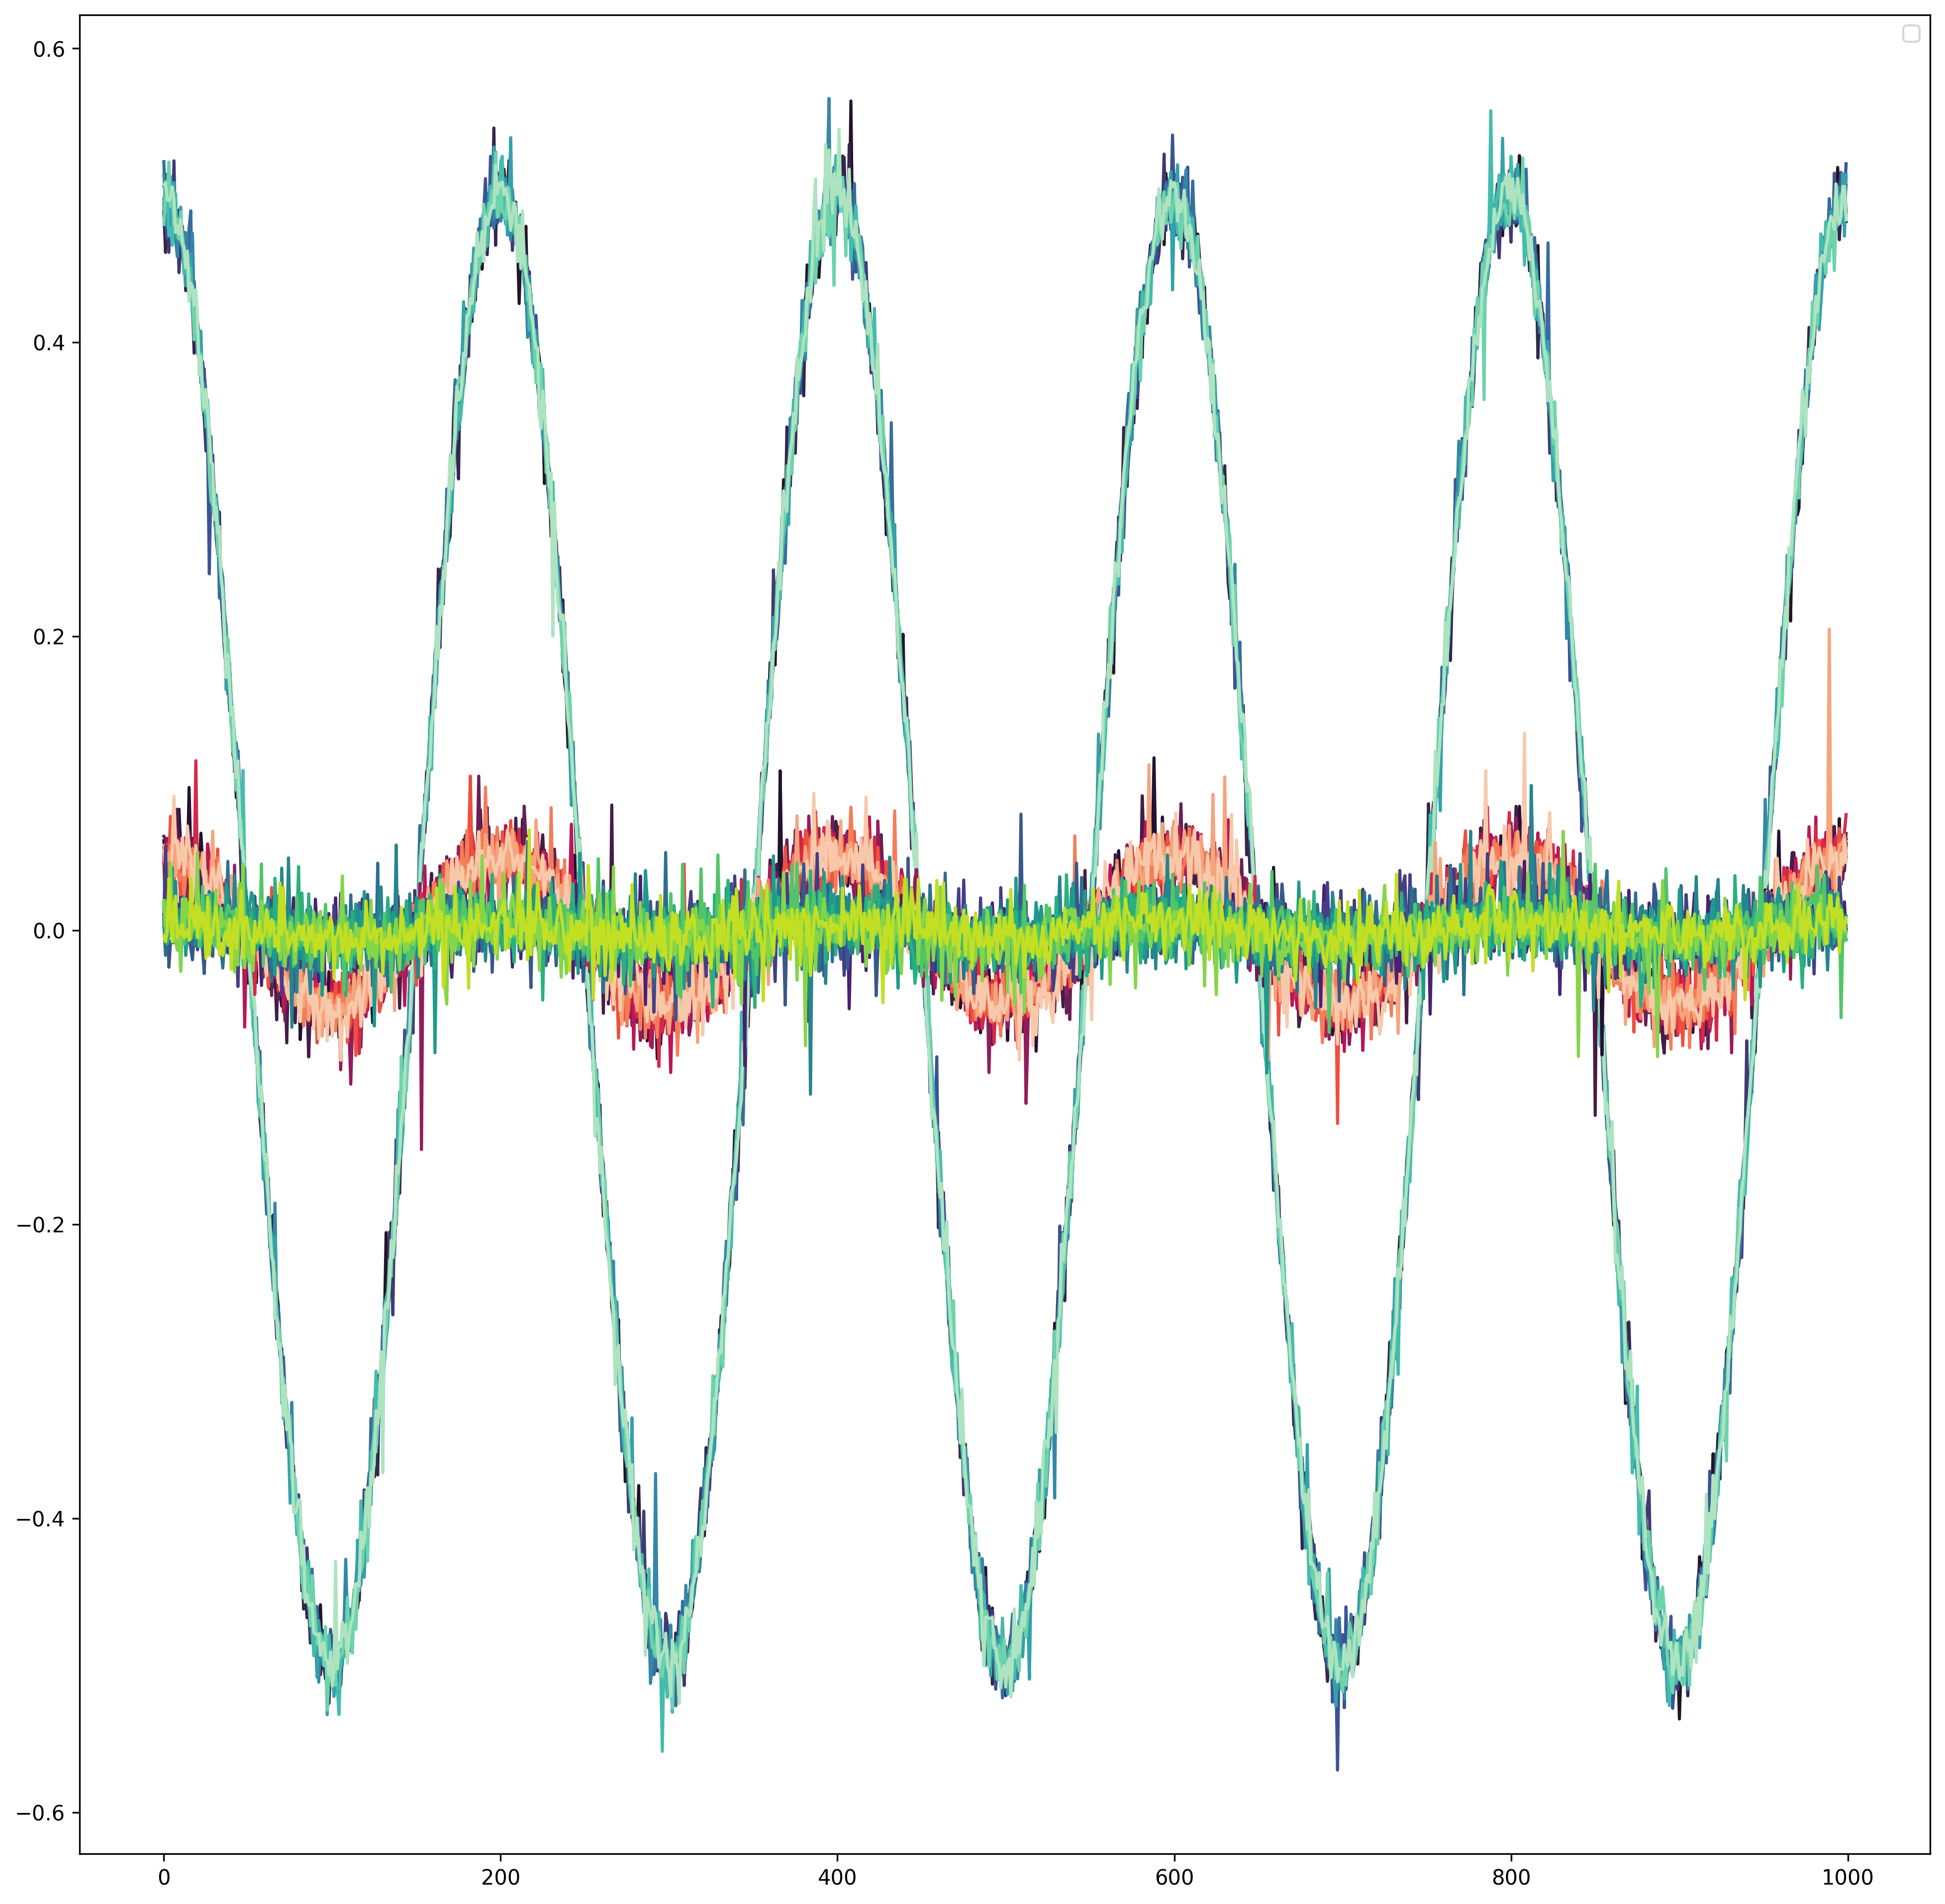

In [6]:
plt.figure(figsize=(16,16), dpi=300)
sns.lineplot(data=large_wave_gen.sample(10).T, palette='mako', dashes=False)
sns.lineplot(data=small_wave_gen.sample(10).T, palette='rocket', dashes=False)
sns.lineplot(data=flat_wave_gen.sample(10).T, palette='viridis', dashes=False)
plt.legend([])
plt.show()

In [7]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors

def torch_data_from_dict(dataset_dict, separate=True):
    tensors = list()
    for label, arr in dataset_dict.items():
        # convert this from arr to tensor after numpy change
        dataset_samples = arr.shape[0]
        input_tensor = torch.from_numpy(arr)
        label_tensor = torch.full((dataset_samples, ), label)
        display(input_tensor.shape)
        display(label_tensor.shape)
        if separate:
            tensors.append((input_tensor, label_tensor))
        else:
            tensor = torch.cat([input_tensor, label_tensor], dim=1)
            tensors.append(tensor)
            
    if separate:
        input_tensors, label_tensors = zip(*tensors)
        input_tensor = torch.cat(input_tensors, dim=0).unsqueeze(axis=1).double()
        label_tensor = torch.cat(label_tensors, dim=0).double()
        display(input_tensor.shape)
        display(label_tensor.shape)
        return input_tensor, label_tensor
    else:
        tensor = torch.cat(tensors, dim=0).double()
        return tensor
    
class TorchDataset(Dataset):
    def __init__(self, input_tensor, label_tensor):
        assert input_tensor.shape[0] == label_tensor.shape[0], f'{input_tensor.shape} != {label_tensor.shape[0]}'
        self._data = input_tensor
        self._label = label_tensor
        return
    
    @property
    def shape(self):
        return self._data.shape

    def __len__(self):
        return self._data.shape[0]

    def __getitem__(self, index):
        data = self._data[index]
        label = self._label[index]
        return data, label

In [8]:
dataset_samples = 10_000

dataset_dict = {
    1. : large_wave_gen.sample(dataset_samples),
    .5 : small_wave_gen.sample(dataset_samples),
    0. : flat_wave_gen.sample(dataset_samples),
}

In [9]:
data, labels = torch_data_from_dict(dataset_dict)
train_data, test_data, train_labels, test_labels = torch_train_test_split(data, labels, split=.9)

train_dataset = TorchDataset(train_data, train_labels)
test_dataset = TorchDataset(test_data, test_labels)

torch.Size([10000, 1000])

torch.Size([10000])

torch.Size([10000, 1000])

torch.Size([10000])

torch.Size([10000, 1000])

torch.Size([10000])

torch.Size([30000, 1, 1000])

torch.Size([30000])

In [10]:
class SineCNN(nn.Module):
    def __init__(self, input_size, out_channels=16, kernel_size=2, stride=4, pool_kernel=4):
        super(SineCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        conv1_out_shape = (input_size - kernel_size) // stride + 1
        self.activation = nn.LeakyReLU(negative_slope=.2)
        self.maxpool = nn.MaxPool1d(kernel_size=pool_kernel)
        pool_out_shape = (conv1_out_shape - pool_kernel) // pool_kernel + 1
        self.fc1 = nn.Linear(pool_out_shape * out_channels, 32)
        self.dout1 = nn.Dropout(p=.4)
        self.fc2 = nn.Linear(32, 1)
        self.output = nn.Sigmoid()
        return
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dout1(x)
        x = self.fc2(x)
        x = self.output(x).squeeze()
        return x

In [11]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_data, train_labels), (test_data, test_labels) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_output = model(train_data)
            
            train_loss = criterion(train_output, train_labels)       
            train_loss.backward()
            optimizer.step()

            test_output = model(test_data)
            test_loss = criterion(test_output, test_labels)

            if p and not epoch % 10:
                print('Train Loss', train_loss.item())
                print('Test Loss', test_loss.item())
                p = False
                
        if test_full:
            train_data, train_label = train_dataset[:]
            test_data, test_label = test_dataset[:]
            train_output = model(train_data)
            train_loss = criterion(train_output, train_label)
            test_output = model(test_data)
            test_loss = criterion(test_output, test_label)
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[-early_stop_patience:]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [12]:
out_channelss = [1,2,4,6]
kernel_sizes = [12,16,24,32,48,64,76]
strides = [1,4,16,None]
pool_kernels = [8,16,32,48,64,76]
total_i = np.prod((len(out_channelss), len(kernel_sizes), len(strides), len(pool_kernels)))

columns = ['out_channels','kernel_size','stride','pool_kernel','train_loss','test_loss']
rows = list()
n_epochs = 6
batch_size = 128
for i, (out_channels, kernel_size, stride, pool_kernel) in enumerate(itertools.product(out_channelss, kernel_sizes, strides, pool_kernels)):
    if stride is None:
        stride = kernel_size
    if stride > kernel_size or stride > pool_kernel:
        continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(out_channels, kernel_size, stride, pool_kernel, sep='\n')
    
    model = SineCNN(
        train_dataset.shape[2] - 1,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        pool_kernel=pool_kernel,
    ).double()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True
        ) 
    except RuntimeError as re:
        print(re)
        continue
        
    train_loss, test_loss = zip(*items)
    assert len(train_loss) == n_epochs
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append((out_channels, kernel_size, stride, pool_kernel, train_loss, test_loss))

grid_df = pd.DataFrame(rows)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d")}.csv')
display(grid_df)

Input Set 1
1
12
1
8
Input Set 2
1
12
1
16
Input Set 3
1
12
1
32
Input Set 4
1
12
1
48
Input Set 5
1
12
1
64
Input Set 6
1
12
1
76
Input Set 7
1
12
4
8
mat1 and mat2 shapes cannot be multiplied (128x31 and 30x32)
Input Set 8
1
12
4
16
Input Set 9
1
12
4
32
Input Set 10
1
12
4
48
Input Set 11
1
12
4
64
Input Set 12
1
12
4
76
Input Set 20
1
12
12
16
Input Set 21
1
12
12
32
Input Set 22
1
12
12
48
Input Set 23
1
12
12
64
Input Set 24
1
12
12
76
Input Set 25
1
16
1
8
Input Set 26
1
16
1
16
Input Set 27
1
16
1
32
Input Set 28
1
16
1
48
Input Set 29
1
16
1
64
Input Set 30
1
16
1
76
Input Set 31
1
16
4
8
Input Set 32
1
16
4
16
Input Set 33
1
16
4
32
Input Set 34
1
16
4
48
Input Set 35
1
16
4
64
Input Set 36
1
16
4
76
Input Set 38
1
16
16
16
Input Set 39
1
16
16
32
Input Set 40
1
16
16
48
Input Set 41
1
16
16
64
Given input size: (1x1x62). Calculated output size: (1x1x0). Output size is too small
Input Set 42
1
16
16
76
Given input size: (1x1x62). Calculated output size: (1x1x0). Output size i

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Input Set 45
1
16
16
32
Input Set 46
1
16
16
48
Input Set 47
1
16
16
64
Given input size: (1x1x62). Calculated output size: (1x1x0). Output size is too small
Input Set 48
1
16
16
76
Given input size: (1x1x62). Calculated output size: (1x1x0). Output size is too small
Input Set 49
1
24
1
8
Input Set 50
1
24
1
16
Input Set 51
1
24
1
32
Input Set 52
1
24
1
48
Input Set 53
1
24
1
64
Input Set 54
1
24
1
76
Input Set 55
1
24
4
8
Input Set 56
1
24
4
16
Input Set 57
1
24
4
32
Input Set 58
1
24
4
48
Input Set 59
1
24
4
64
Input Set 60
1
24
4
76
Input Set 62
1
24
16
16
Input Set 63
1
24
16
32
Input Set 64
1
24
16
48
Input Set 65
1
24
16
64
Given input size: (1x1x62). Calculated output size: (1x1x0). Output size is too small
Input Set 66
1
24
16
76
Given input size: (1x1x62). Calculated output size: (1x1x0). Output size is too small
Input Set 69
1
24
24
32
Input Set 70
1
24
24
48
Given input size: (1x1x41). Calculated output size: (1x1x0). Output size is too small
Input Set 71
1
24
24
64
Given in

Input Set 274
2
48
4
48
Input Set 275
2
48
4
64
Input Set 276
2
48
4
76
Input Set 278
2
48
16
16
Input Set 279
2
48
16
32
Input Set 280
2
48
16
48
Input Set 281
2
48
16
64
Given input size: (2x1x60). Calculated output size: (2x1x0). Output size is too small
Input Set 282
2
48
16
76
Given input size: (2x1x60). Calculated output size: (2x1x0). Output size is too small
Input Set 286
2
48
48
48
Given input size: (2x1x20). Calculated output size: (2x1x0). Output size is too small
Input Set 287
2
48
48
64
Given input size: (2x1x20). Calculated output size: (2x1x0). Output size is too small
Input Set 288
2
48
48
76
Given input size: (2x1x20). Calculated output size: (2x1x0). Output size is too small
Input Set 289
2
64
1
8
Input Set 290
2
64
1
16
Input Set 291
2
64
1
32
Input Set 292
2
64
1
48
Input Set 293
2
64
1
64
Input Set 294
2
64
1
76
Input Set 295
2
64
4
8
Input Set 296
2
64
4
16
Input Set 297
2
64
4
32
Input Set 298
2
64
4
48
Input Set 299
2
64
4
64
Input Set 300
2
64
4
76
Input Set 30

Input Set 511
6
12
4
8
mat1 and mat2 shapes cannot be multiplied (128x186 and 180x32)
Input Set 512
6
12
4
16
Input Set 513
6
12
4
32
Input Set 514
6
12
4
48
Input Set 515
6
12
4
64
Input Set 516
6
12
4
76
Input Set 524
6
12
12
16
Input Set 525
6
12
12
32
Input Set 526
6
12
12
48
Input Set 527
6
12
12
64
Input Set 528
6
12
12
76
Input Set 529
6
16
1
8
Input Set 530
6
16
1
16
Input Set 531
6
16
1
32
Input Set 532
6
16
1
48
Input Set 533
6
16
1
64
Input Set 534
6
16
1
76
Input Set 535
6
16
4
8
Input Set 536
6
16
4
16
Input Set 537
6
16
4
32
Input Set 538
6
16
4
48
Input Set 539
6
16
4
64
Input Set 540
6
16
4
76
Input Set 542
6
16
16
16
Input Set 543
6
16
16
32
Input Set 544
6
16
16
48
Input Set 545
6
16
16
64
Given input size: (6x1x62). Calculated output size: (6x1x0). Output size is too small
Input Set 546
6
16
16
76
Given input size: (6x1x62). Calculated output size: (6x1x0). Output size is too small
Input Set 548
6
16
16
16
Input Set 549
6
16
16
32
Input Set 550
6
16
16
48
Input Set 5

,out_channels,kernel_size,stride,pool_kernel,train_loss,test_loss
0,1,12,1,8,0.018701,0.018562
1,1,12,1,16,0.041104,0.041231
2,1,12,1,32,0.037361,0.037206
3,1,12,1,48,0.041887,0.041962
4,1,12,1,64,0.035575,0.035613
...,...,...,...,...,...,...
431,6,76,4,64,0.030348,0.030251
432,6,76,4,76,0.028549,0.028865
433,6,76,16,16,0.033066,0.033146
434,6,76,16,32,0.038191,0.038518


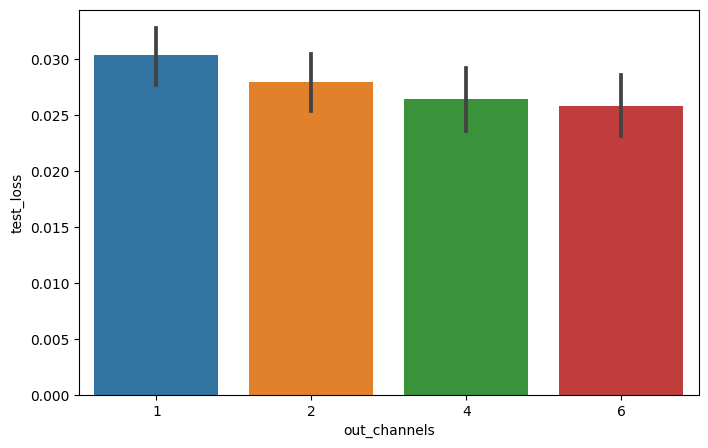

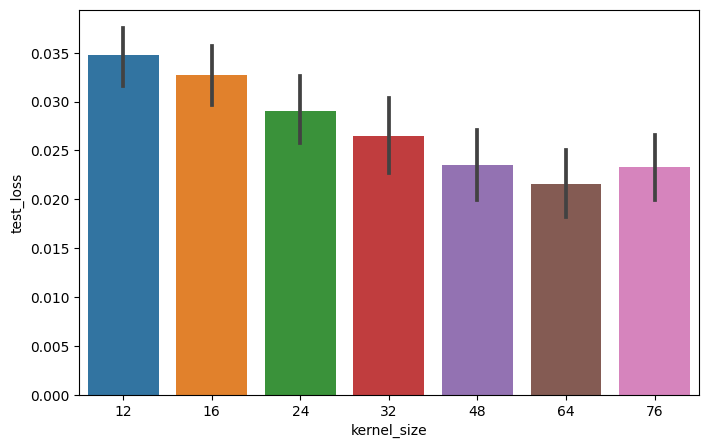

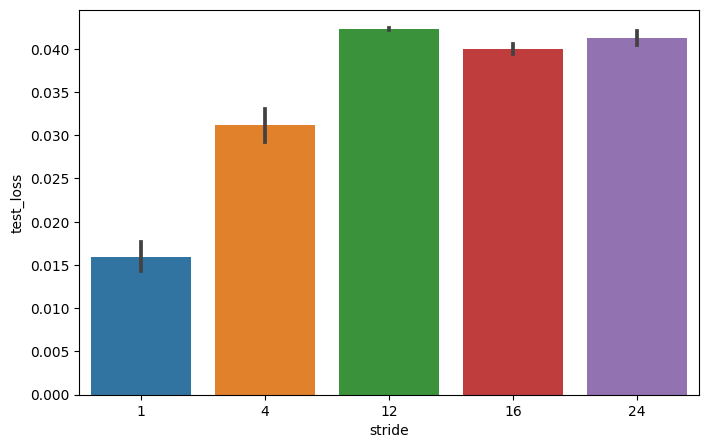

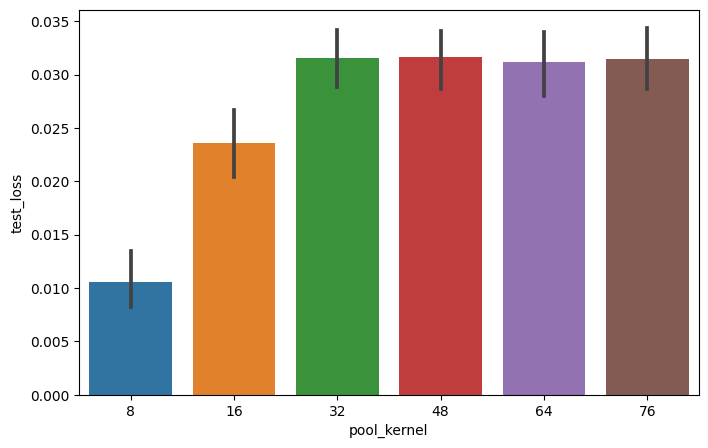

In [13]:
for col in ['out_channels','kernel_size','stride','pool_kernel']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

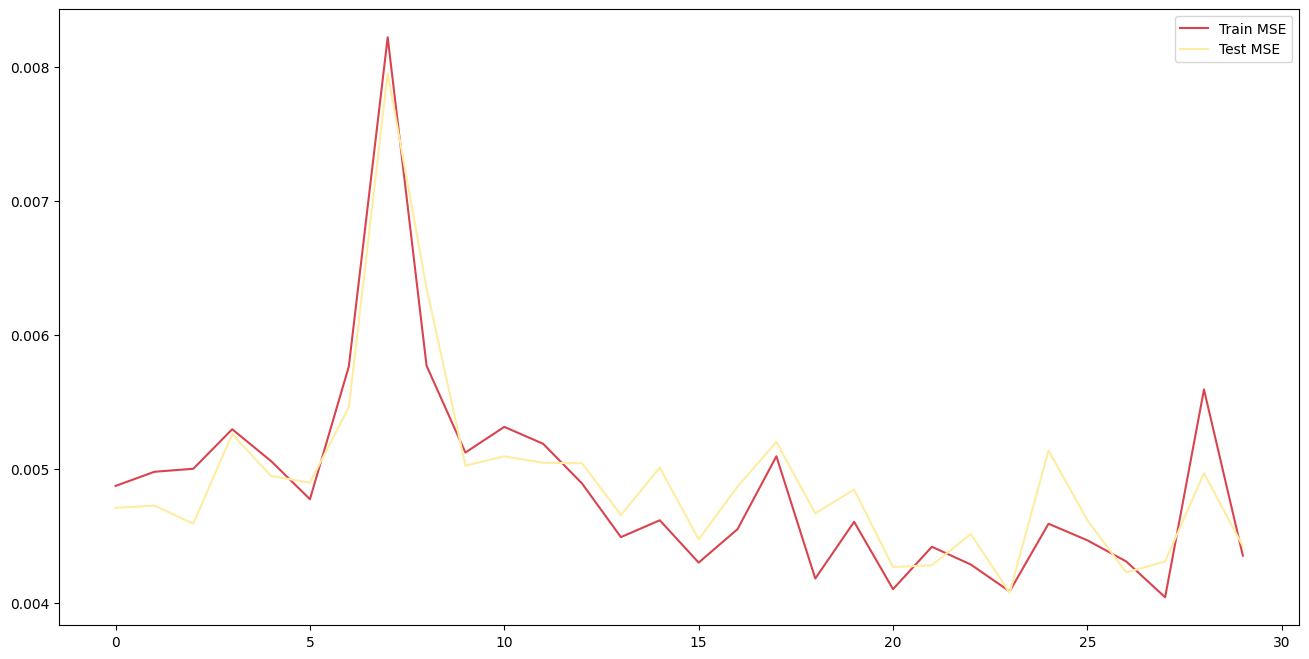

In [14]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

# display(best_out_channels, best_kernel_size, best_stride, best_pool_kernel)
model = SineCNN(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).double()

model, items = train(model, train_dataset, test_dataset, n_epochs=100, test_full=True, early_stop_patience=30) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_model.pt')